In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# ================================================
# 1. Geometry Definition: Slope, Layer Boundary, Groundwater Table
# ================================================

# Slope outline points
slope_outline = [
    (0, 0), (15.4, 7), (17.4, 7), (31.4, 14), (40, 14),
    (40, -5), (-5, -5), (-5, 0), (0, 0)
]

# Layer boundary
layer_boundary = [(15.4, 7), (40, 7)]

# Groundwater line (rising + horizontal)
groundwater_line = [(-5, 0), (0, 0), (15.4, 7), (40, 7)]

# Saturated zone as polygon
saturated_zone = groundwater_line + [(40, -5), (-5, -5), (-5, 0)]

# Soil zones A and B
soil_A = [(0, 0), (15.4, 7), (17.4, 7), (31.4, 14), (40, 14), (40, 7), (15.4, 7), (0, 0)]
soil_B = [(40, 7), (40, -5), (-5, -5), (-5, 0), (0, 0), (15.4, 7)]

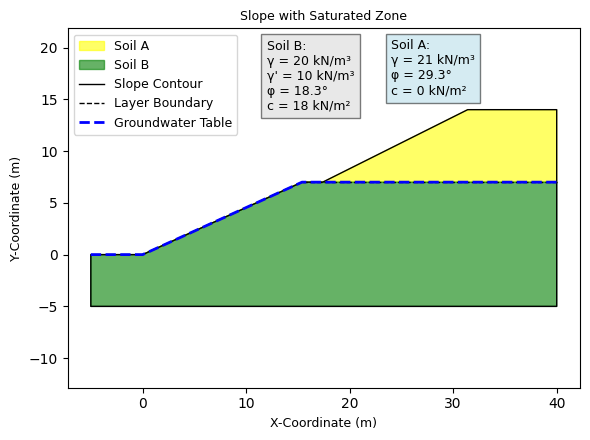

In [3]:
# ================================================
# 2. Plot: Geometry Overview
# ================================================

plt.figure(figsize=(6, 4.5))
plt.fill(*zip(*soil_A), color='yellow', alpha=0.6, label="Soil A")
plt.fill(*zip(*soil_B), color='green', alpha=0.6, label="Soil B")

x_vals, y_vals = zip(*slope_outline)
plt.plot(x_vals, y_vals, linestyle='-', color='k', linewidth=1, label='Slope Contour')
plt.plot(*zip(*layer_boundary), 'k--', linewidth=1, label='Layer Boundary')
plt.plot(*zip(*groundwater_line), 'b--', linewidth=2, label='Groundwater Table')

# Annotate soil parameters with fontsize=9
plt.text(24, 15.5, "Soil A:\nγ = 21 kN/m³\nφ = 29.3°\nc = 0 kN/m²",
         fontsize=9, color='black', bbox=dict(facecolor='lightblue', alpha=0.5))
plt.text(12, 14, "Soil B:\nγ = 20 kN/m³\nγ' = 10 kN/m³\nφ = 18.3°\nc = 18 kN/m²",
         fontsize=9, color='black', bbox=dict(facecolor='lightgrey', alpha=0.5))

# Set axes labels and title with fontsize=9
plt.xlabel("X-Coordinate (m)", fontsize=9)
plt.ylabel("Y-Coordinate (m)", fontsize=9)
plt.title("Slope with Saturated Zone", fontsize=9)
plt.grid(False)
plt.legend(fontsize=9)
plt.axis("equal")
plt.tight_layout()

# Save the plot to a PNG file and display it
plt.savefig("slope_geometry.png", dpi=300)
plt.show()
plt.close()

In [4]:
# ================================================
# 3. Bishop Function (Generic, with α)
# ================================================

def bishop_eta(slices, rel_tolerance=0.03, max_iter=100):
    """
    Iterative calculation of the factor of safety (FoS) using Bishop's simplified method.
    Each slice must have methods: weight(), pore_pressure(), and attributes:
    soil.cohesion, soil.phi, alpha, and width b.
    """
    eta = 1.0
    for iteration in range(max_iter):
        num = denom = 0.0
        for s in slices:
            W = s.weight()
            u = s.pore_pressure()
            c = s.soil.cohesion
            phi = s.soil.phi
            alpha = s.alpha
            b = s.b

            safe_eta = max(eta, 1e-3)
            m_i = np.cos(alpha) + (np.tan(phi) * np.sin(alpha)) / safe_eta

            num += (c * b + (W - u * b) * np.tan(phi)) / m_i
            denom += W * np.sin(alpha)

        new_eta = num / denom if abs(denom) > 1e-6 else np.inf
        rel_err = abs(new_eta - eta) / max(eta, 1e-6)
        if rel_err < rel_tolerance:
            print(f"Converged after {iteration+1} iterations (rel. error: {rel_err:.4f})")
            return new_eta
        eta = new_eta

    print("Warning: Bishop iteration did not converge within tolerance.")
    return eta

In [5]:
# ================================================
# 4. Geometry of the Slip Circle and Equal-Width Slice Generation
# ================================================

slope_upper = [
    (0, 0), (15.4, 7), (17.4, 7), (31.4, 14), (36, 14)
]
x_slope, y_slope = zip(*slope_upper)
x_slope = np.array(x_slope)
y_slope = np.array(y_slope)

slope_surface = interp1d(x_slope, y_slope, kind='linear', bounds_error=False, fill_value='extrapolate')

x1, y1 = 0, 0
x2, y2 = 36, 14
y_center = 35

numerator = x2**2 - x1**2 + y2**2 - y1**2 + 2 * y_center * (y1 - y2)
denominator = 2 * (x2 - x1)
x_center = numerator / denominator
radius = np.sqrt((x_center - x1)**2 + (y_center - y1)**2)

x_start = 0
x_end = 36
n_slices = 10
slice_width = (x_end - x_start) / n_slices
n_interp = 20

slices = []
slice_data = []

for i in range(n_slices):
    x_left = x_start + i * slice_width
    x_right = x_left + slice_width
    xs = np.linspace(x_left, x_right, n_interp)

    ys_top = slope_surface(xs)
    ys_bottom = y_center - np.sqrt(np.maximum(0, radius**2 - (xs - x_center)**2))

    poly_x = list(xs) + list(xs[::-1])
    poly_y = list(ys_top) + list(ys_bottom[::-1])
    slices.append(list(zip(poly_x, poly_y)))

    x_c = (x_left + x_right) / 2
    y_c = (np.mean(ys_top) + np.mean(ys_bottom)) / 2
    slice_data.append({'x': x_c, 'y': y_c})


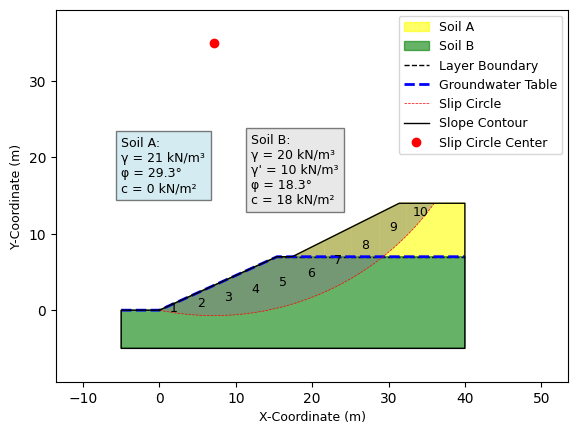

In [7]:
# ================================================
# 5. Plot: Slope, Soil Layers, Groundwater, Slip Circle, and Numbered Slices
# ================================================

boeschung_x = [p[0] for p in slope_outline]
boeschung_y = [p[1] for p in slope_outline]

gwl = [(-5, 0), (0, 0), (15.4, 7), (40, 7)]
theta1 = np.arctan2(y1 - y_center, x1 - x_center)
theta2 = np.arctan2(y2 - y_center, x2 - x_center)
theta_arc = np.linspace(theta1, theta2, 300)
arc_x = x_center + radius * np.cos(theta_arc)
arc_y = y_center + radius * np.sin(theta_arc)

plt.figure(figsize=(6, 4.5))

plt.fill(*zip(*soil_A), color='yellow', alpha=0.6, label="Soil A")
plt.fill(*zip(*soil_B), color='green', alpha=0.6, label="Soil B")
plt.plot(*zip(*layer_boundary), 'k--', linewidth=1, label='Layer Boundary')
plt.plot(*zip(*gwl), 'b--', linewidth=2, label='Groundwater Table')
plt.plot(arc_x, arc_y, 'r--', linewidth=0.5, label="Slip Circle")
plt.plot(boeschung_x, boeschung_y, 'k-', linewidth=1.0, label='Slope Contour')
plt.plot(x_center, y_center, 'ro', label='Slip Circle Center')

for idx, (poly, center) in enumerate(zip(slices, slice_data)):
    xs, ys = zip(*poly)
    plt.fill(xs, ys, color='gray', alpha=0.5, edgecolor='none')
    plt.text(center['x'], center['y'], str(idx + 1), fontsize=9, ha='center', va='center')

# Annotate soil parameters with fontsize=9
plt.text(-5, 15.5, "Soil A:\nγ = 21 kN/m³\nφ = 29.3°\nc = 0 kN/m²",
         fontsize=9, color='black', bbox=dict(facecolor='lightblue', alpha=0.5))
plt.text(12, 14, "Soil B:\nγ = 20 kN/m³\nγ' = 10 kN/m³\nφ = 18.3°\nc = 18 kN/m²",
         fontsize=9, color='black', bbox=dict(facecolor='lightgrey', alpha=0.5))


plt.xlabel("X-Coordinate (m)", fontsize=9)
plt.ylabel("Y-Coordinate (m)", fontsize=9)
plt.grid(False)
plt.legend(fontsize=9)
plt.axis("equal")
plt.xlim(-5, 45)
plt.ylim(-10, 40)
plt.tight_layout()

plt.savefig("slope_slices.png", dpi=300)
plt.show()
plt.close()

In [56]:
# ================================================
# 6. Computation of Soil Parameters per Slice
# ================================================

gwl_interp = interp1d([pt[0] for pt in gwl], [pt[1] for pt in gwl],
                      bounds_error=False, fill_value="extrapolate")

phi_a = np.radians(29.3)
phi_b = np.radians(18.3)
c_a = 0
c_b = 18
gamma_a = 21
gamma_b = 20
gamma_w = 10.0
layer_y = 7.0

transition_index = None
for idx, slice_poly in enumerate(slices):
    xL = min(p[0] for p in slice_poly)
    xR = max(p[0] for p in slice_poly)
    yL_bot = y_center - np.sqrt(np.maximum(0, radius**2 - (xL - x_center)**2))
    yR_bot = y_center - np.sqrt(np.maximum(0, radius**2 - (xR - x_center)**2))
    if min(yL_bot, yR_bot) <= layer_y <= max(yL_bot, yR_bot):
        transition_index = idx
        break

slice_parameters = []

for idx, slice_poly in enumerate(slices):
    poly = np.array(slice_poly)
    xL = np.min(poly[:, 0])
    xR = np.max(poly[:, 0])
    b = xR - xL

    y_top_left = slope_surface(xL)
    y_top_right = slope_surface(xR)
    y_top = (y_top_left + y_top_right) / 2

    yL_bot = y_center - np.sqrt(np.maximum(0, radius**2 - (xL - x_center)**2))
    yR_bot = y_center - np.sqrt(np.maximum(0, radius**2 - (xR - x_center)**2))
    y_bot = (yL_bot + yR_bot) / 2

    h = y_top - y_bot

    x_c = (xL + xR) / 2
    theta = np.arcsin((x_c - x_center) / radius)

    y_gwl = gwl_interp(x_c)
    h_water = max(0, y_gwl - y_bot)
    u = gamma_w * h_water
    u_b = u * b

    if transition_index is not None:
        if idx < transition_index:
            phi_deg = np.degrees(phi_b)
            c = c_b
        elif idx == transition_index:
            xs_fine = np.linspace(xL, xR, 200)
            ys_circle = y_center - np.sqrt(np.maximum(0, radius**2 - (xs_fine - x_center)**2))
            in_a = ys_circle >= layer_y
            in_b = ys_circle < layer_y
            b_a = np.sum(in_a) / len(xs_fine) * b
            b_b = np.sum(in_b) / len(xs_fine) * b
            phi_mixed = np.arctan((b_a * np.tan(phi_a) + b_b * np.tan(phi_b)) / b)
            phi_deg = np.degrees(phi_mixed)
            c = (c_a * b_a + c_b * b_b) / b
        else:
            phi_deg = np.degrees(phi_a)
            c = c_a
    else:
        phi_deg = np.degrees(phi_b)
        c = c_b

    if y_top > layer_y and y_bot < layer_y:
        h_a = max(0, y_top - layer_y)
        h_b = max(0, layer_y - y_bot)
        G = b * (gamma_a * h_a + gamma_b * h_b)
    else:
        if y_top > layer_y:
            G = gamma_a * b * h
        else:
            G = gamma_b * b * h

    slice_parameters.append({
        'b': b,
        'c': c,
        'phi_rad': np.radians(phi_deg),
        'G': G,
        'u_b': u_b,
        'theta': theta
    })

In [57]:
# ================================================
# 7. Bishop Iteration: Computation of Safety Factor F
# ================================================

print("\nComputing safety factor F using Bishop’s method (iterative, numerically stabilized):")

F = 1.0
tol = 0.03
max_iter = 100
diff = 1.0
iteration = 0

while diff > tol and iteration < max_iter:
    num = 0.0
    denom = 0.0

    for s in slice_parameters:
        b = s['b']
        c = s['c']
        phi = s['phi_rad']
        G = s['G']
        ub = s['u_b']
        theta = s['theta']

        tan_phi = np.tan(phi)
        sin_theta = np.sin(theta)
        cos_theta = np.cos(theta)
        safe_F = max(F, 1e-6)
        m_i = cos_theta + (tan_phi * sin_theta) / safe_F

        if abs(m_i) < 1e-8:
            print(f" Warning: very small m_i in slice {s}")
            continue

        num += (c * b + (G - ub) * tan_phi) / m_i
        denom += G * sin_theta

    if denom == 0:
        print("Error: denominator in Bishop equation is zero. Cannot compute F.")
        F = np.nan
        break

    F_new = num / denom
    diff = abs(F_new - F) / max(F, 1e-6)
    F = F_new
    iteration += 1

if np.isnan(F):
    print("\nResult: Safety factor could not be computed (NaN).")
else:
    print(f"\nSafety factor F = {F:.4f} (after {iteration} iterations)")



Computing safety factor F using Bishop’s method (iterative, numerically stabilized):

Safety factor F = 1.1495 (after 2 iterations)


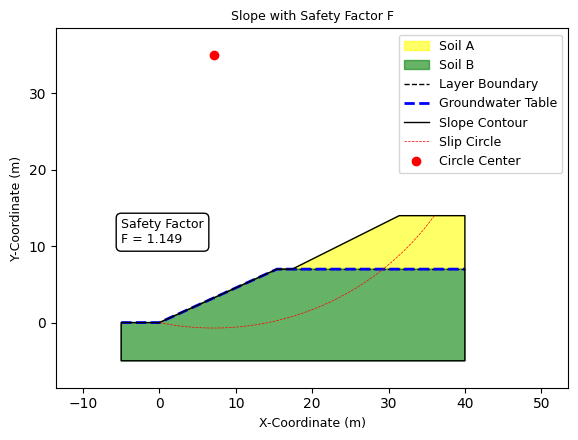

In [72]:
# ================================================
# 8. Final Overview Plot with Geometry and Safety Factor
# ================================================

theta1 = np.arctan2(y1 - y_center, x1 - x_center)
theta2 = np.arctan2(y2 - y_center, x2 - x_center)
theta_arc = np.linspace(theta1, theta2, 300)
arc_x = x_center + radius * np.cos(theta_arc)
arc_y = y_center + radius * np.sin(theta_arc)

plt.figure(figsize=(6, 4.5))

# Plot elements (top right group)
plt.fill(*zip(*soil_A), color='yellow', alpha=0.6, label='Soil A')
plt.fill(*zip(*soil_B), color='green', alpha=0.6, label='Soil B')
plt.plot(*zip(*layer_boundary), 'k--', linewidth=1, label='Layer Boundary')
plt.plot(*zip(*gwl), 'b--', linewidth=2, label='Groundwater Table')
plt.plot(boeschung_x, boeschung_y, 'k-', linewidth=1.0, label='Slope Contour')
plt.plot(arc_x, arc_y, 'r--', linewidth=0.5, label='Slip Circle')
plt.plot(x_center, y_center, 'ro', label='Circle Center')

# Safety factor text (top left)
if not np.isnan(F):
    plt.text(-5, 10, f"Safety Factor\nF = {F:.3f}", fontsize=9,
             ha='left', va='bottom',
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'))

plt.xlabel("X-Coordinate (m)", fontsize=9)
plt.ylabel("Y-Coordinate (m)", fontsize=9)
plt.title("Slope with Safety Factor F", fontsize=9)
plt.grid(False)
plt.legend(fontsize=9, loc='upper right')
plt.axis("equal")
plt.xlim(-5, 45)
plt.ylim(-10, 40)
plt.tight_layout()

plt.savefig("slope_summary_plot.png", dpi=300)
plt.show()
plt.close()